In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split

from keras.applications import ResNet50
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

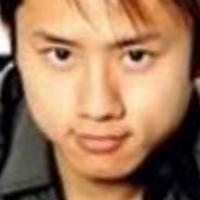

26 0


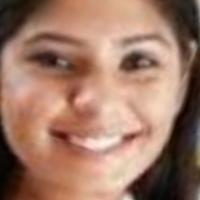

21 1


In [4]:
import os
from PIL import Image
import pandas as pd

images = []
ages = []
genders = []

for i in os.listdir('../input/utkface-new/crop_part1/')[0:8000]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open('../input/utkface-new/crop_part1/' + i))

images = pd.Series(list(images), name='Images')
ages = pd.Series(list(ages), name='Ages')
genders = pd.Series(list(genders), name='Genders')

df = pd.concat([images, ages, genders], axis=1)
df

display(df['Images'][0])
print(df['Ages'][0], df['Genders'][0])

display(df['Images'][1])
print(df['Ages'][1], df['Genders'][1])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


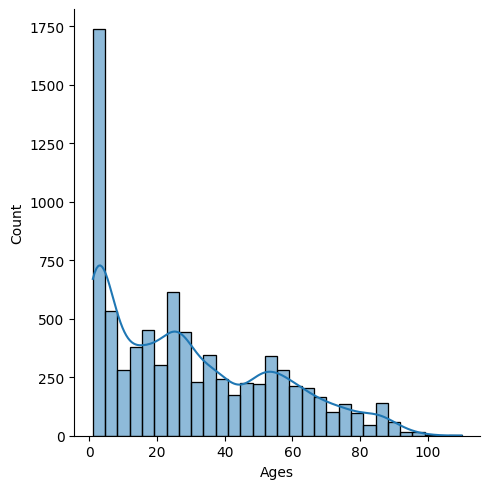

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


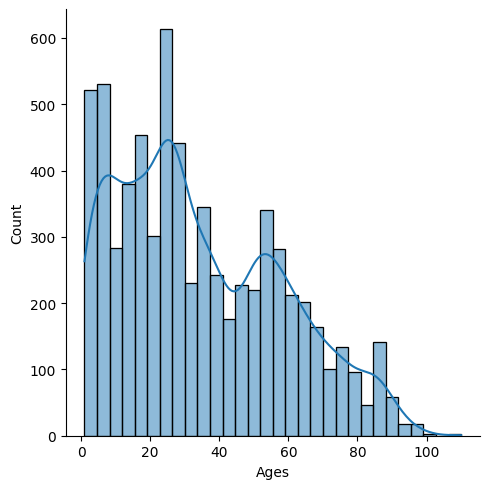

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


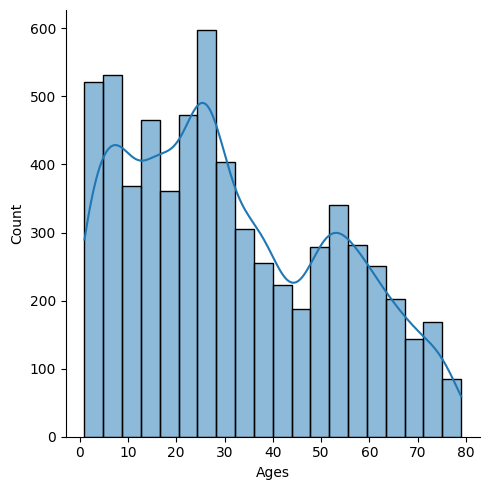

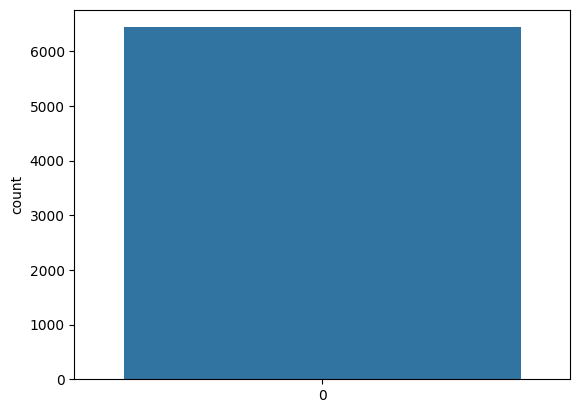

In [5]:
import matplotlib.pyplot as plt


# Plot initial age distribution
sns.displot(df['Ages'], kde=True, bins=30)
plt.show()

# Filter and sample data for ages <= 4
under4s = df[df['Ages'] <= 4].sample(frac=0.3)
df = pd.concat([df[df['Ages'] > 4], under4s], ignore_index=True)

# Plot age distribution after filtering
sns.displot(df['Ages'], kde=True, bins=30)
plt.show()

# Remove ages > 80
df = df[df['Ages'] < 80]

# Plot age distribution after removing ages > 80
sns.displot(df['Ages'], kde=True, bins=20)
plt.show()

# Remove entries with gender = 3
df = df[df['Genders'] != 3]

# Plot gender distribution after filtering gender = 3
sns.countplot(df['Genders'])
plt.show()

# Resize images and prepare data for training
x = []
y = []

for i in range(len(df)):
    resized_image = df['Images'].iloc[i].resize((200, 200), Image.LANCZOS).copy()
    ar = np.asarray(resized_image)
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
    y.append(agegen)

x = np.array(x)

# Continue with the rest of your code as needed

In [6]:
y_age = df['Ages']
y_gender = df['Genders']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [7]:
from tensorflow.keras import layers

# Age Model
age_model = Sequential()
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

age_model.add(resnet_model)
age_model.add(GlobalAveragePooling2D())
age_model.add(Dense(128, activation='relu'))
age_model.add(Dropout(0.5))
age_model.add(Dense(64, activation='relu'))
age_model.add(Dropout(0.5))
age_model.add(Dense(1, activation='linear'))  # Linear activation for regression

age_model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(lr=0.0001),
                  metrics=['accuracy'])

# Gender Model
gender_model = Sequential()
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

gender_model.add(resnet_model)
gender_model.add(GlobalAveragePooling2D())
gender_model.add(Dense(128, activation='relu'))
gender_model.add(Dropout(0.5))
gender_model.add(Dense(64, activation='relu'))
gender_model.add(Dropout(0.5))
gender_model.add(Dense(1, activation='sigmoid'))

gender_model.compile(loss='binary_crossentropy',
                     optimizer=optimizers.Adam(lr=0.0001),
                     metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Age Model Training
datagen_age = ImageDataGenerator(
    rescale=1./255., width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

test_datagen_age = ImageDataGenerator(rescale=1./255)

train_age = datagen_age.flow(x_train_age, y_train_age, batch_size=32)
test_age = test_datagen_age.flow(x_test_age, y_test_age, batch_size=32)

history_age = age_model.fit(train_age, epochs=50, shuffle=True, validation_data=test_age)

# Gender Model Training
datagen_gender = ImageDataGenerator(
    rescale=1./255., width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

test_datagen_gender = ImageDataGenerator(rescale=1./255)

train_gender = datagen_gender.flow(x_train_gender, y_train_gender, batch_size=64)
test_gender = test_datagen_gender.flow(x_test_gender, y_test_gender, batch_size=64)

history_gender = gender_model.fit(train_gender, epochs=50, shuffle=True, validation_data=test_gender)

# Print the training history
print("Age Model Training History:")
print("Training Loss:", history_age.history['loss'])
print("Validation Loss:", history_age.history['val_loss'])
print("Training Accuracy:", history_age.history['accuracy'])
print("Validation Accuracy:", history_age.history['val_accuracy'])

print("\nGender Model Training History:")
print("Training Loss:", history_gender.history['loss'])
print("Validation Loss:", history_gender.history['val_loss'])
print("Training Accuracy:", history_gender.history['accuracy'])
print("Validation Accuracy:", history_gender.history['val_accuracy'])

Epoch 1/50
161/161 [==============================] - 87s 274ms/step - loss: 367.1549 - accuracy: 0.0427 - val_loss: 1208.4824 - val_accuracy: 0.0427
Epoch 2/50
161/161 [==============================] - 43s 268ms/step - loss: 252.0816 - accuracy: 0.0425 - val_loss: 1319.6542 - val_accuracy: 0.0427
Epoch 3/50
161/161 [==============================] - 43s 266ms/step - loss: 226.8857 - accuracy: 0.0425 - val_loss: 769.0809 - val_accuracy: 0.0427
Epoch 4/50
161/161 [==============================] - 43s 267ms/step - loss: 216.9538 - accuracy: 0.0427 - val_loss: 411.1989 - val_accuracy: 0.0427
Epoch 5/50
161/161 [==============================] - 43s 265ms/step - loss: 191.3260 - accuracy: 0.0427 - val_loss: 239.8218 - val_accuracy: 0.0427
Epoch 6/50
161/161 [==============================] - 43s 264ms/step - loss: 187.6052 - accuracy: 0.0427 - val_loss: 295.6937 - val_accuracy: 0.0427
Epoch 7/50
161/161 [==============================] - 43s 264ms/step - loss: 185.9280 - accuracy: 0.0427

In [ ]:
# Retrieve final accuracy values for Age Model
final_training_accuracy_age = history_age.history.get('accuracy', history_age.history.get('acc'))
final_validation_accuracy_age = history_age.history.get('val_accuracy', history_age.history.get('val_acc'))

if final_training_accuracy_age is not None:
    final_training_accuracy_age = final_training_accuracy_age[-1] if isinstance(final_training_accuracy_age, list) else final_training_accuracy_age
    print("Age Model Final Training Accuracy:", final_training_accuracy_age)
else:
    print("Age Model Training Accuracy not available.")

if final_validation_accuracy_age is not None:
    final_validation_accuracy_age = final_validation_accuracy_age[-1] if isinstance(final_validation_accuracy_age, list) else final_validation_accuracy_age
    print("Age Model Final Validation Accuracy:", final_validation_accuracy_age)
else:
    print("Age Model Validation Accuracy not available.")

# Retrieve final accuracy values for Gender Model
final_training_accuracy_gender = history_gender.history.get('accuracy', history_gender.history.get('acc'))
final_validation_accuracy_gender = history_gender.history.get('val_accuracy', history_gender.history.get('val_acc'))

if final_training_accuracy_gender is not None:
    final_training_accuracy_gender = final_training_accuracy_gender[-1] if isinstance(final_training_accuracy_gender, list) else final_training_accuracy_gender
    print("Gender Model Final Training Accuracy:", final_training_accuracy_gender)
else:
    print("Gender Model Training Accuracy not available.")

if final_validation_accuracy_gender is not None:
    final_validation_accuracy_gender = final_validation_accuracy_gender[-1] if isinstance(final_validation_accuracy_gender, list) else final_validation_accuracy_gender
    print("Gender Model Final Validation Accuracy:", final_validation_accuracy_gender)
else:
    print("Gender Model Validation Accuracy not available.")

In [ ]:
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((200,200), Image.ANTIALIAS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
            
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)
    
    age = agemodel.predict(ar)
    gender = np.round(genmodel.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'
        
    print('Age:', int(age), '\n Gender:', gender)
    return im.resize((300,300), Image.ANTIALIAS)

In [ ]:
# Process and predict function for ResNet50 models
def process_and_predict_resnet50(file, age_model, gender_model):
    im = Image.open(file)
    im = im.resize((200, 200), Image.ANTIALIAS)
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)

    age = age_model.predict(ar)
    gender = np.round(gender_model.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'

    print('Age:', int(age), '\n Gender:', gender)
    return im.resize((300, 300), Image.ANTIALIAS)

age_model.save('/kaggle/working/age_model_resnet.h5')
gender_model.save('/kaggle/working/gender_model_resnet.h5') 

# Celebrities prediction with ResNet50 models
process_and_predict_resnet50('../input/celebrity/s1.jpg', age_model, gender_model)
process_and_predict_resnet50('../input/celebrity/s2.jpg', age_model, gender_model)
process_and_predict_resnet50('../input/celebrity/s3.jpg', age_model, gender_model)
process_and_predict_resnet50('../input/celebrity/s4.jpg', age_model, gender_model)

In [ ]:
process_and_predict_resnet50('../input/celebrity/s3.jpg', age_model, gender_model)

In [ ]:
#Inception v3
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split

from keras.applications import InceptionV3
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical



y_age = df['Ages']
y_gender = df['Genders']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)

In [ ]:
from tensorflow.keras import layers

# Age Model with InceptionV3
age_model_inception = Sequential()
inception_model_age = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

age_model_inception.add(inception_model_age)
age_model_inception.add(GlobalAveragePooling2D())
age_model_inception.add(Dense(128, activation='relu'))
age_model_inception.add(Dropout(0.5))
age_model_inception.add(Dense(64, activation='relu'))
age_model_inception.add(Dropout(0.5))
age_model_inception.add(Dense(1, activation='linear'))  # Linear activation for regression

age_model_inception.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Gender Model with InceptionV3
gender_model_inception = Sequential()
inception_model_gender = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

gender_model_inception.add(inception_model_gender)
gender_model_inception.add(GlobalAveragePooling2D())
gender_model_inception.add(Dense(128, activation='relu'))
gender_model_inception.add(Dropout(0.5))
gender_model_inception.add(Dense(64, activation='relu'))
gender_model_inception.add(Dropout(0.5))
gender_model_inception.add(Dense(1, activation='sigmoid'))

gender_model_inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Training the Models

# Age Model Training
datagen_age = ImageDataGenerator(
    rescale=1./255., width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

test_datagen_age = ImageDataGenerator(rescale=1./255)

train_age = datagen_age.flow(x_train_age, y_train_age, batch_size=32)
test_age = test_datagen_age.flow(x_test_age, y_test_age, batch_size=32)

history_age_inception = age_model_inception.fit(train_age, epochs=50, shuffle=True, validation_data=test_age)

# Gender Model Training
datagen_gender = ImageDataGenerator(
    rescale=1./255., width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

test_datagen_gender = ImageDataGenerator(rescale=1./255)

train_gender = datagen_gender.flow(x_train_gender, y_train_gender, batch_size=64)
test_gender = test_datagen_gender.flow(x_test_gender, y_test_gender, batch_size=64)

history_gender_inception = gender_model_inception.fit(train_gender, epochs=50, shuffle=True, validation_data=test_gender)

In [ ]:
# Evaluate the Age Model on the test dataset
test_loss_age_inception, test_accuracy_age_inception = age_model_inception.evaluate(test_age)
print(f'Test Age Model Accuracy (Inception): {test_accuracy_age_inception * 100:.2f}%')

# Evaluate the Gender Model on the test dataset
test_loss_gender_inception, test_accuracy_gender_inception = gender_model_inception.evaluate(test_gender)
print(f'Test Gender Model Accuracy (Inception): {test_accuracy_gender_inception * 100:.2f}%')

In [ ]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50, InceptionV3, VGG16
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [ ]:
from tensorflow.keras import layers

# Age Model with VGG16
age_model_vgg16 = Sequential()
vgg16_model_age = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

age_model_vgg16.add(vgg16_model_age)
age_model_vgg16.add(GlobalAveragePooling2D())
age_model_vgg16.add(Dense(128, activation='relu'))
age_model_vgg16.add(Dropout(0.5))
age_model_vgg16.add(Dense(64, activation='relu'))
age_model_vgg16.add(Dropout(0.5))
age_model_vgg16.add(Dense(1, activation='linear'))  # Linear activation for regression

age_model_vgg16.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Gender Model with VGG16
gender_model_vgg16 = Sequential()
vgg16_model_gender = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

gender_model_vgg16.add(vgg16_model_gender)
gender_model_vgg16.add(GlobalAveragePooling2D())
gender_model_vgg16.add(Dense(128, activation='relu'))
gender_model_vgg16.add(Dropout(0.5))
gender_model_vgg16.add(Dense(64, activation='relu'))
gender_model_vgg16.add(Dropout(0.5))
gender_model_vgg16.add(Dense(1, activation='sigmoid'))

gender_model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Training the Models

# Age Model Training using VGG16
datagen_age = ImageDataGenerator(
    rescale=1./255., width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

test_datagen_age = ImageDataGenerator(rescale=1./255)

train_age = datagen_age.flow(x_train_age, y_train_age, batch_size=32)
test_age = test_datagen_age.flow(x_test_age, y_test_age, batch_size=32)

history_age_vgg16 = age_model_vgg16.fit(train_age, epochs=50, shuffle=True, validation_data=test_age)

# Gender Model Training using VGG16
datagen_gender = ImageDataGenerator(
    rescale=1./255., width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

test_datagen_gender = ImageDataGenerator(rescale=1./255)

train_gender = datagen_gender.flow(x_train_gender, y_train_gender, batch_size=64)
test_gender = test_datagen_gender.flow(x_test_gender, y_test_gender, batch_size=64)

In [ ]:
history_gender_vgg16 = gender_model_vgg16.fit(train_gender, epochs=50, shuffle=True, validation_data=test_gender)

# Evaluate the Age Model on the test dataset using VGG16
test_loss_age_vgg16, test_accuracy_age_vgg16 = age_model_vgg16.evaluate(test_age)
print(f'Test Age Model Accuracy (VGG16): {test_accuracy_age_vgg16 * 100:.2f}%')

# Evaluate the Gender Model on the test dataset using VGG16
test_loss_gender_vgg16, test_accuracy_gender_vgg16 = gender_model_vgg16.evaluate(test_gender)
print(f'Test Gender Model Accuracy (VGG16): {test_accuracy_gender_vgg16 * 100:.2f}%')

In [ ]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss
def plot_history(history, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot ResNet50 Age Model
plot_history(history_age, 'ResNet50 Age')

# Plot ResNet50 Gender Model
plot_history(history_gender, 'ResNet50 Gender')

# Plot InceptionV3 Age Model
plot_history(history_age_inception, 'InceptionV3 Age')

# Plot InceptionV3 Gender Model
plot_history(history_gender_inception, 'InceptionV3 Gender')

# Plot VGG16 Age Model
plot_history(history_age_vgg16, 'VGG16 Age')

# Plot VGG16 Gender Model
plot_history(history_gender_vgg16, 'VGG16 Gender')
